<h1>Sentence Embeddings with BiLSTM</h1>

<p>The cleaned sentences are padded and applied through encoder decoder model to generate sentence embeddings of equal size. The embeddings are optimized to fit MLP based regression model </p>

<p>Observations: The dataset is too less to generate representative embeddings. More data and more deep neural layers required</p>

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
train_df = pd.read_csv('../data/cleaned_train_df.csv')
val_df = pd.read_csv('../data/cleaned_val_df.csv')
test_df = pd.read_csv('../data/cleaned_test_df.csv')

In [ ]:
train_df['sent1'] = train_df['sent1'].apply(eval)
train_df['sent2'] = train_df['sent2'].apply(eval)

In [ ]:
val_df['sent1'] = val_df['sent1'].apply(eval)
val_df['sent2'] = val_df['sent2'].apply(eval)

In [ ]:
test_df['sent1'] = test_df['sent1'].apply(eval)
test_df['sent2'] = test_df['sent2'].apply(eval)

In [ ]:
import pickle
with open("../data/word_dict.pickle", 'rb') as handle:
      word_dict = pickle.load(handle)

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader

# Define the model architecture
class RNNSentenceEncoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, bidirectional=True):
        super(RNNSentenceEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=num_layers, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn(x)
        x = self.fc(x[:, -1, :])
        x = self.relu(x)
        return x

def sent_indicies(sent1):
    vocab = {}
    for i, (word1, word2) in enumerate(sent1):
        if word1 not in vocab:
            vocab[word1] = len(vocab)
        if word2 not in vocab:
            vocab[word2] = len(vocab)

    # Convert the list to a list of numerical indices
    lst_indices = []
    for word1, word2 in sent1:
        lst_indices.append((vocab[word1], vocab[word2]))
    return lst_indices
    
class SimilarityModel(nn.Module):
    def __init__(self, sentence_encoder):
        super(SimilarityModel, self).__init__()
        self.encoder = sentence_encoder
        self.mlp = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        
    def forward(self, sentences1, sentences2):
        
        #print(sent_indicies(sentences1))
        #print(sentences1)
        
        #encoded1 = self.encoder(torch.tensor(sent_indicies(sentences1)))
        #encoded2 = self.encoder(torch.tensor(sent_indicies(sentences2)))
        #encoded1 = self.encoder(torch.tensor(sentences1))
        #encoded2 = self.encoder(torch.tensor(sentences2))
        encoded1 = self.encoder(sentences1)
        encoded2 = self.encoder(sentences2)
        concatenated = torch.cat([encoded1, encoded2], dim=1)
        output = self.mlp(concatenated)
        return output

# Define the dataset
class MyDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.vocab = list(word_dict)
        self.vocab.append('unk')
        self.vocab.append('<pad>')
        #self.vocab = ['<OOV>', 'apple', 'banana', 'orange', 'cat', 'dog', 'grape', 'hello', 'world', '<pad>']
        
    def __len__(self):
        return len(self.df)
    
    def get_indexes(self, sentence, max_len=100):
        indexed_sentence = []
        for word in sentence:
            if word in self.vocab:
                indexed_sentence.append(self.vocab.index(word))
            else:
                indexed_sentence.append(self.vocab.index('unk'))
        diff = abs(max_len - len(indexed_sentence))
        if diff > 0:
            for i in range(diff):
                indexed_sentence.append(self.vocab.index('<pad>'))
        return indexed_sentence
    
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        sentence1 = self.get_indexes(row['sent1'])
        sentence2 = self.get_indexes(row['sent2'])
        similarity_score = row['score']
        return torch.tensor(sentence1), torch.tensor(sentence2), torch.tensor(similarity_score, dtype=torch.float32)

# Define the training function
def train(model, num_epochs, train_loader, val_loader, optimizer, criterion, device):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch_idx, (sentences1, sentences2, similarity_scores) in enumerate(train_loader):
            # move data to device
            sentences1, sentences2, similarity_scores = sentences1.to(device), sentences2.to(device), similarity_scores.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(sentences1, sentences2)
            loss = criterion(outputs, similarity_scores.view(-1, 1))
            loss.backward()
            optimizer.step()

            # calculate statistics
            train_loss += loss.item()
            #train_correct += torch.sum(torch.abs(outputs - similarity_scores.view(-1, 1)) <= 0.5)

#             if batch_idx % 100 == 99:
#                 print(f'Train Batch {batch_idx+1}/{len(train_loader)} Loss: {train_loss/(batch_idx+1):.4f}')

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

         # Evaluate the model on the validation set
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_idx, (sentences1, sentences2, similarity_scores) in enumerate(val_loader):
                val_output = model(sentences1, sentences2)
                loss = criterion(val_output, similarity_scores.view(-1, 1))
                val_loss += loss.item()
                #val_loss += loss_fn(val_output.squeeze(), scores_batch).item() * len(embeddings1_batch)
            val_loss /= len(val_loader)
            val_losses.append(val_loss)

            #train_accuracy = train_correct.double() / len(train_loader.dataset)
        print('Epoch {} - Training Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch+1, train_loss, val_loss))
    return train_losses, val_losses

In [ ]:
# Define the hyperparameters
vocab_size = 10000
embedding_dim = 50
hidden_dim = 128
num_layers = 2
bidirectional = True
learning_rate = 0.001
batch_size = 10
num_epochs = 10

# Initialize the dataset and dataloader
dataset = MyDataset(train_df)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
val_dataset = MyDataset(val_df)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Initialize the model and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sentence_encoder = RNNSentenceEncoder(vocab_size, embedding_dim, hidden_dim, num_layers, bidirectional)
model = SimilarityModel(sentence_encoder).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Initialize the loss function
criterion = nn.MSELoss()

train_losses, val_losses = train(model, num_epochs, dataloader, val_dataloader, optimizer, criterion, device)

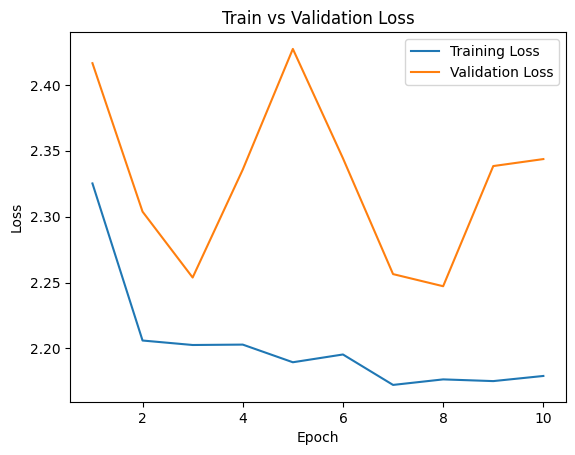

In [1]:
import matplotlib.pyplot as plt



# Define the data
epochs = range(1, 11)
#train_losses = train_loss
#val_losses = val_loss

# Plot the data
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
# create the test dataset and data loader
test_dataset = MyDataset(test_df)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# set the model in evaluation mode
model.eval()

# iterate over the test data and get the model output
model_output = []
with torch.no_grad():
    for sentences1, sentences2, similarity_scores in test_loader:
        # move data to device
        sentences1, sentences2 = sentences1.to(device), sentences2.to(device)
        # get the model output
        output = model(sentences1, sentences2)
        # append the output to the list
        model_output.append(output.cpu().numpy())

# concatenate the output from all batches into a single array
model_output = np.concatenate(model_output)

# convert the output array to a list
model_output = model_output.squeeze().tolist()

In [ ]:
y_test = list(test_df['score'])

In [ ]:
corr = pearson_corr(y_test, model_output)

# Print the correlation coefficient
print("Pearson correlation coefficient: {:.2f}".format(corr))